> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 

In [1]:
!nvidia-smi

Tue Oct 13 22:16:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Подгрузим все необходимые библиотеки и модули.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'train.csv', 'test.zip', 'sample-submission.csv']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [3]:
!pip freeze > requirements.txt

# Основные настройки

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 15  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 256 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
train_df['Category'].nunique()

10

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


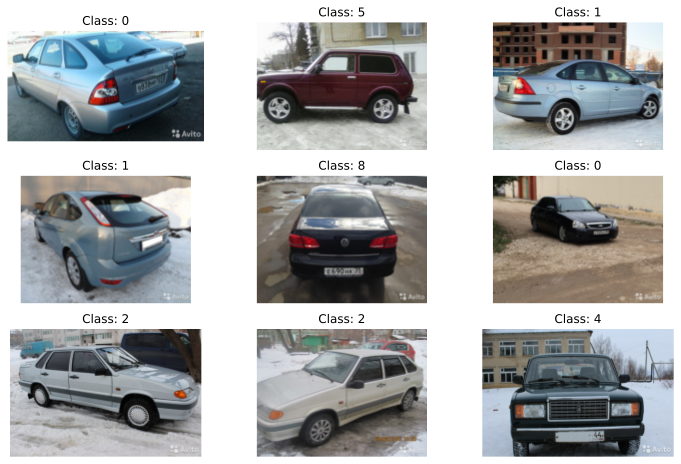

In [11]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

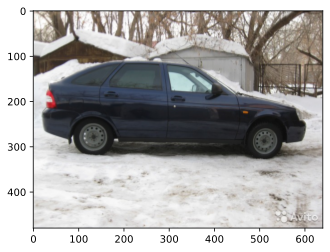

(640, 480)

In [12]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Аугментация данных

In [13]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

# test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [14]:
# Установка библиотек аугментации изображений
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-dog9dbml
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=28027 sha256=9ab03bfd6f6b13a35b376984a3e5c0a8bb44cb0b0a5d8fb52344abbbe969853e
  Stored in directory: /tmp/pip-ephem-wheel-cache-43qhjmxi/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor


Воспользуемся библиотекой Albumentation для аугментации изображений датасета**

In [15]:
# !pip install -q -U albumentations
# !echo "$(pip freeze | grep albumentations) успешно установлен"

In [16]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations
    
AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
#         albumentations.CenterCrop(height=250, width=200),
#         albumentations.CenterCrop(height=200, width=250),
#         albumentations.Resize(IMG_SIZE, IMG_SIZE)
    ], p=0.5),
    
    
#     albumentations.OneOf([
#         albumentations.RandomGamma(),
# #         albumentations.RandomBrightness(),
#         albumentations.RandomContrast()
#     ],p=0.3),
    
    albumentations.OneOf([
        albumentations.ElasticTransform(),
#         alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albumentations.GridDistortion(),
        albumentations.OpticalDistortion(),
#         distort_limit=2, shift_limit=0.5),
    ],p=0.01),
    
    albumentations.OneOf([
        albumentations.IAAAdditiveGaussianNoise(),
        albumentations.GaussNoise(),
    ], p=0.2),
    
    albumentations.OneOf([
        albumentations.MotionBlur(p=0.2),
        albumentations.MedianBlur(blur_limit=3, p=0.1),
        albumentations.Blur(blur_limit=(10, 10), p=0.1),
    ], p=0.2),
    
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=20, p=0.2),
    
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2),
        albumentations.IAASharpen(),
        albumentations.IAAEmboss(),
    ], p=0.3),
        
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
#     albumentations.RGBShift(p=0.5),
    albumentations.ChannelShuffle(p=0.05),
    
], p=0.8)


# AUGMENTATIONS = albumentations.Compose([
#     albumentations.HorizontalFlip(p=0.5),
#     albumentations.OneOf([
#         albumentations.RandomGamma(),
#         albumentations.RandomBrightness(),
#         albumentations.RandomContrast()
#     ],p=0.3),
#     albumentations.OneOf([
#         albumentations.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
#         albumentations.GridDistortion(),
#         albumentations.OpticalDistortion(distort_limit=2, shift_limit=0.5),
#     ],p=0.3),
#     albumentations.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.6, rotate_limit=0, p=0.7)
# ])


train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    preprocess_input=None,
    validation_split=VAL_SPLIT
)
        
test_datagen = ImageDataAugmentor(
    rescale=1./255
)


# train_generator = train_datagen.flow_from_directory(
#     PATH+'train/',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     shuffle=True, seed=RANDOM_SEED,
#     subset='training')
        
# test_generator = test_datagen.flow_from_directory(
#     PATH+'train/',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,
#     class_mode='binary',
#     subset='validation')

# test_sub_generator = test_datagen.flow_from_dataframe( 
#     dataframe=sample_submission,
#     directory=PATH+'test_upload/',
#     x_col="Id",
#     y_col=None,
#     shuffle=False,
#     class_mode=None,
#     seed=RANDOM_SEED,
#     target_size=(IMG_SIZE, IMG_SIZE),
#     batch_size=BATCH_SIZE,)

# #train_generator.show_batch() #<- for visualization

# model.fit_generator(
#         train_generator,
#         steps_per_epoch=len(train_generator),
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=len(validation_generator))

### Генерация данных

In [17]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Пример картинок из train_generator 13232


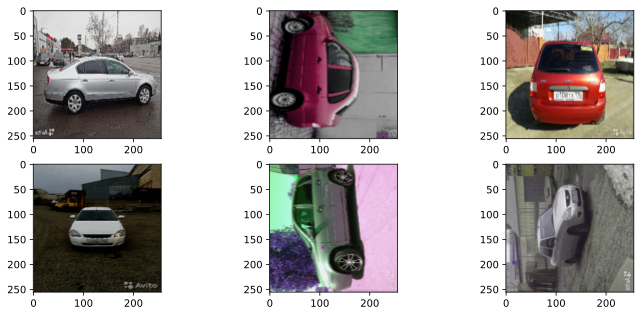

In [18]:
# from skimage import io

# def imshow(image_RGB):
#     io.imshow(image_RGB)
#     io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator', (train_generator.samples))
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

### Загружаем предобученную сеть Xception:

In [19]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [20]:
base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [21]:
# Устанавливаем новую "голову" (head)

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [22]:
model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

## Обучение модели

Добавим ModelCheckpoint, чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.  
Также добавим EarlyStopping для остановки обучения, когда метрика перестает улучшаться.  
ReduceLROnPlateau - для снижения скорости обучения, когда метрика перестает улучшаться.


In [23]:
def scheduler(epoch, lr):
    #y1 = np.sin(epoch * np.pi / 180 * 20 - 5) + 1
    y1 = (np.sin(epoch * 3.14 / 180 * 37 - 5) + 1.2) / 2.2
    #y2 = -0.036 * epoch + 1
    y2 = (1.013 * np.exp(-0.06 * epoch))
    return lr * (y1 * y2)


checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, verbose=1,
                              mode='auto', min_delta=0.0001, cooldown=1, min_lr=1e-6)
scheduler = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, earlystop, reduce_lr, scheduler]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

Обучаем:

In [24]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

# Рекомендация: попробуйте применить transfer learning с fine-tuning

Epoch 1/15
414/414 [==============================] - ETA: 0s - loss: 1.0584 - accuracy: 0.6158
Epoch 00001: saving model to best_model.hdf5
414/414 [==============================] - 242s 584ms/step - loss: 1.0584 - accuracy: 0.6158 - val_loss: 0.5233 - val_accuracy: 0.8106
Epoch 2/15
414/414 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8488
Epoch 00002: saving model to best_model.hdf5
414/414 [==============================] - 238s 575ms/step - loss: 0.4285 - accuracy: 0.8488 - val_loss: 0.3936 - val_accuracy: 0.8596
Epoch 3/15
414/414 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8951
Epoch 00003: saving model to best_model.hdf5
414/414 [==============================] - 240s 580ms/step - loss: 0.2982 - accuracy: 0.8951 - val_loss: 0.3298 - val_accuracy: 0.8854
Epoch 4/15
414/414 [==============================] - ETA: 0s - loss: 0.2293 - accuracy: 0.9219
Epoch 00004: saving model to best_model.hdf5
414/414 [======================

In [25]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [26]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

73/73 [==============================] - 23s 310ms/step - loss: 0.2501 - accuracy: 0.9064
Accuracy: 90.64%


В Итоге точность нашей модели составила 93%. 
Учитывая что классов 10 - это Очень хороший результат!     
Посмотрим графики обучения:

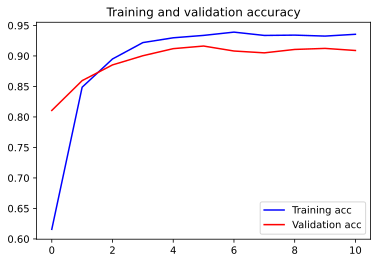

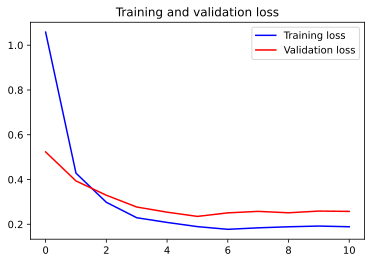

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Предсказание на тестовых данных

In [28]:
test_sub_generator.samples

6675

In [29]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

209/209 [==============================] - 50s 238ms/step


In [30]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Save submit


In [31]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


In [32]:
model.load_weights('best_model.hdf5')

In [33]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.HorizontalFlip(p=0.8),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ], p=0.5),
    
    albumentations.OneOf([
        albumentations.ElasticTransform(),
        albumentations.GridDistortion(),
        albumentations.OpticalDistortion(),
    ],p=0.01),
    
    albumentations.OneOf([
        albumentations.IAAAdditiveGaussianNoise(),
        albumentations.GaussNoise(),
    ], p=0.2),
    
    albumentations.OneOf([
        albumentations.MotionBlur(p=0.2),
        albumentations.MedianBlur(blur_limit=3, p=0.1),
        albumentations.Blur(blur_limit=(10, 10), p=0.1),
    ], p=0.2),
    
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.5, rotate_limit=20, p=0.2),
    
    albumentations.OneOf([
        albumentations.CLAHE(clip_limit=2),
        albumentations.IAASharpen(),
        albumentations.IAAEmboss(),
    ], p=0.3),
        
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.ChannelShuffle(p=0.05),
    
], p=0.8)

In [34]:
test_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    preprocess_input=None
)
        
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
)

Found 6675 validated image filenames.


In [35]:
tta_steps = 10
predictions_list = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions_list.append(preds)

pred = np.mean(predictions_list, axis=0)

209/209 [==============================] - 71s 338ms/step


In [36]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_sub_generator.filenames

In [37]:
# submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
# submission['Id'] = submission['Id'].replace('test_upload/','')
# submission.to_csv('/content/gdrive/My Drive/car_class/submission_waveTTA.csv', index=False)

In [38]:
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


In [39]:
# Clean PATH
import shutil
shutil.rmtree(PATH)

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!